# mmFace + InsightFace2D Hybrid Model

## Build and Load Dataset

Real Dataset:
- 21 Subjects, 15 Experiments
  * Total 250 data frames -> Shuffle -> Take first 15 frames and split
  * Total 10 RGB embeddings -> Filter undetected -> Shuffle and Fill 15 frames and split

`15*15*21 = 4725 Data Points`

Fake Dataset:
- 21 Subjects, 3 Experiments
  * Total 74 ARD frames -> Shuffle -> Split
  * Total 10 RGB embeddings -> Filter undetected -> Shuffle and Fill 74 frames and split

`74*3*21 = 4662 Data Points`

`NB: If no RGB embedding for an subject experiment, need to completely remove that`

In [1]:
from hybrid_dataset import load_dataset, load_dataset_subject, load_aug_dataset_subject, get_rgb_emb_aug, get_ard_aug
from tqdm import tqdm
import numpy as np
import torch
import os

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device, '\n')

RAW_PATH = os.path.relpath("../../Soli/soli_realsense/data")
num_subjects = 21
seed = 42

torch.cuda.empty_cache()
# train, validation, test = load_dataset(RAW_PATH, num_subjects)
# train, validation, test = load_dataset_subject(RAW_PATH, num_subjects, batch_size=128, train_split=15/21, test_split=3/21, seed=seed)
train, test, test_idx = load_aug_dataset_subject(RAW_PATH, num_subjects, batch_size=128, device=device)

Applied providers: ['CUDAExecutionProvider', 'CPUExecutionProvider'], with options: {'CUDAExecutionProvider': {'do_copy_in_default_stream': '1', 'cudnn_conv_algo_search': 'EXHAUSTIVE', 'device_id': '0', 'gpu_external_alloc': '0', 'enable_cuda_graph': '0', 'gpu_mem_limit': '18446744073709551615', 'gpu_external_free': '0', 'gpu_external_empty_cache': '0', 'arena_extend_strategy': 'kNextPowerOfTwo', 'cudnn_conv_use_max_workspace': '1', 'cudnn_conv1d_pad_to_nc1d': '0', 'tunable_op_enable': '0', 'tunable_op_tuning_enable': '0', 'enable_skip_layer_norm_strict_mode': '0'}, 'CPUExecutionProvider': {}}
Applied providers: ['CUDAExecutionProvider', 'CPUExecutionProvider'], with options: {'CUDAExecutionProvider': {'do_copy_in_default_stream': '1', 'cudnn_conv_algo_search': 'EXHAUSTIVE', 'device_id': '0', 'gpu_external_alloc': '0', 'enable_cuda_graph': '0', 'gpu_mem_limit': '18446744073709551615', 'gpu_external_free': '0', 'gpu_external_empty_cache': '0', 'arena_extend_strategy': 'kNextPowerOfTwo',

## Model Creation and Loading

In [2]:
from neural_nets import MMFaceHybrid
from utils import load_model, load_history
from torch import nn

num_epochs = 80
learning_rate = 0.01

lambda1, lambda2 = 1, 1

model = MMFaceHybrid(num_subjects).to(device)

# Loss + Optimiser
criterion = nn.CrossEntropyLoss()
optimiser = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=0.001, momentum=0.9)

model_name = f"mmFace-hybrid-zero-shot.pt"
cur_epoch, loss_history, train_acc, val_acc = load_model(model_name, model, optimiser)

if len(loss_history) > 0:
    print(f"{model_name}\n\tEpoch: {cur_epoch}\n\tLoss: {loss_history[-1]:.4f}\n\tTrain Accuracy: {train_acc[-1]}\n\tValidation Accuracy: {val_acc[-1]}")

[Errno 2] No such file or directory: 'models/mmFace-hybrid-zero-shot.pt'


## Training

In [ ]:
for epoch in range(cur_epoch, num_epochs):
    print(f"\nEpoch [{epoch}/{num_epochs-1}]:")
    if os.path.exists(f"models/{model_name}"):
        loss_history, train_acc, val_acc = load_history(f"models/{model_name}")

    model.train()
    # Running Loss and Accuracy
    running_loss, running_acc_s, running_acc_l, total_s, total_l = 0., 0., 0., 0., 0.

    for radar, rgb_emb, labels_s, labels_l in tqdm(train):
        # Forward Pass
        out1, out2 = model(radar, rgb_emb)
        _, preds_s = torch.max(out1.data, 1)
        _, preds_l = torch.max(out2.data, 1)
        loss1 = criterion(out1, labels_s)
        loss2 = criterion(out2, labels_l)
        loss = lambda1*loss1 + lambda2*loss2

        # Backward Pass and Optimise
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

        running_loss += loss.item()
        total_s += labels_s.size(0)
        total_l += labels_l.size(0)
        running_acc_s += (preds_s == labels_s).sum().item()
        running_acc_l += (preds_l == labels_l).sum().item()

        del radar, rgb_emb, labels_s, labels_l, out1, out2
        torch.cuda.empty_cache()
    
    avg_train_loss = running_loss/len(train)
    avg_train_acc_s = 100*running_acc_s/total_s
    avg_train_acc_l = 100*running_acc_l/total_l
    print(f"\tAverage Train Loss: {avg_train_loss:.4f}")
    print(f"\tTrain Accuracy (Subjects): {avg_train_acc_s:.4f}%")
    print(f"\tTrain Accuracy (Liveness): {avg_train_acc_l:.4f}%")

    torch.save({"epoch": epoch+1,
                "model_state_dict": model.state_dict(),
                "optimiser_state_dict": optimiser.state_dict(),
                "loss_history": loss_history + [avg_train_loss],
                "train_acc": train_acc + [(avg_train_acc_s, avg_train_acc_l)],
                "val_acc": val_acc},
                f"models/{model_name}")
    
    # Validation
    # model.eval()
    # with torch.no_grad():
    #     correct_s, correct_l, total_s, total_l = 0., 0., 0., 0.
    #     for radar, rgb_emb, labels_s, labels_l in validation:
    #         out1, out2 = model(radar, rgb_emb)
    #         _, preds_s = torch.max(out1.data, 1)
    #         _, preds_l = torch.max(out2.data, 1)
    #         total_s += labels_s.size(0)
    #         total_l += labels_l.size(0)
    #         correct_s += (preds_s == labels_s).sum().item()
    #         correct_l += (preds_l == labels_l).sum().item()
    #         del radar, rgb_emb, labels_s, labels_l, out1, out2
        
    #     avg_val_acc_s = 100*correct_s/total_s
    #     avg_val_acc_l = 100*correct_l/total_l
    #     print(f"\tValidation Accuracy (Subject): {avg_val_acc_s:.4f}%")
    #     print(f"\tValidation Accuracy (Liveness): {avg_val_acc_l:.4f}%")

    # model_checkpoint = torch.load(f"models/{model_name}")
    # model_checkpoint["val_acc"].append((avg_val_acc_s, avg_val_acc_l))
    # torch.save(model_checkpoint, f"models/{model_name}")

## Testing

In [ ]:
preds_subject, preds_liveness = [], []
true_subject, true_liveness = [], []

model.eval()
with torch.no_grad():
    correct_s, correct_l, total_s, total_l = 0., 0., 0., 0.
    for radar, rgb_emb, labels_s, labels_l in test:
        out1, out2 = model(radar, rgb_emb)
        _, preds_s = torch.max(out1.data, 1)
        _, preds_l = torch.max(out2.data, 1)
        total_s += labels_s.size(0)
        total_l += labels_l.size(0)
        correct_s += (preds_s == labels_s).sum().item()
        correct_l += (preds_l == labels_l).sum().item()

        preds_subject.extend(preds_s.cpu().numpy())
        preds_liveness.extend(preds_l.cpu().numpy())
        true_subject.extend(labels_s.data.cpu().numpy())
        true_liveness.extend(labels_l.data.cpu().numpy())
        del radar, rgb_emb, labels_s, labels_l, out1, out2
    
    print(f"Test Accuracy (Subject): {100*correct_s/total_s:.4f}%")
    print(f"Test Accuracy (Liveness): {100*correct_l/total_l:.4f}%")

print(true_subject)
print(preds_subject)

Test Accuracy (Subject): 18.1472%
Test Accuracy (Liveness): 97.5888%
[10, 18, 17, 4, 18, 16, 18, 10, 11, 1, 1, 17, 0, 4, 18, 14, 4, 14, 0, 5, 20, 5, 20, 9, 17, 8, 7, 10, 11, 16, 10, 13, 3, 11, 9, 8, 14, 6, 8, 17, 9, 5, 7, 14, 17, 5, 17, 10, 0, 14, 11, 8, 18, 7, 1, 9, 11, 4, 14, 17, 9, 0, 3, 4, 14, 5, 12, 9, 2, 9, 7, 17, 7, 7, 15, 1, 10, 10, 1, 2, 8, 19, 11, 20, 20, 13, 8, 12, 10, 2, 8, 10, 15, 0, 7, 18, 6, 0, 2, 13, 10, 8, 1, 10, 11, 17, 8, 4, 0, 0, 12, 0, 18, 20, 7, 17, 10, 12, 6, 5, 14, 16, 16, 17, 19, 1, 18, 7, 3, 6, 17, 3, 15, 13, 2, 18, 16, 20, 7, 1, 10, 16, 7, 14, 16, 12, 6, 6, 3, 11, 2, 17, 14, 17, 7, 18, 8, 16, 16, 3, 3, 0, 6, 3, 5, 11, 5, 2, 2, 8, 9, 18, 18, 16, 16, 1, 15, 4, 1, 13, 16, 7, 9, 18, 17, 5, 3, 1, 20, 18, 2, 11, 6, 18, 20, 8, 17, 6, 13, 12, 2, 5, 0, 14, 7, 1, 11, 5, 20, 2, 13, 10, 3, 17, 9, 11, 19, 13, 3, 17, 18, 13, 15, 19, 2, 0, 8, 16, 9, 9, 0, 4, 16, 19, 2, 8, 20, 5, 6, 11, 11, 18, 11, 1, 15, 20, 19, 20, 3, 6, 12, 8, 14, 3, 1, 18, 9, 10, 5, 3, 7, 8, 5, 10, 17, 1

### Testing by Similarity

In [3]:
def search_flatten(embeddings, labels, unseen_embeddings, threshold=0.5):
    pred_names = []
    for emb in unseen_embeddings:
        scores = np.dot(emb, embeddings.T)
        scores = np.clip(scores, 0., 1.)

        idx = np.argmax(scores)
        if scores[idx] > threshold:
            pred_names.append(labels[idx])
        else:
            pred_names.append(None)
    
    return pred_names

test_subjects = [i if i < num_subjects else int(f"9{(i-num_subjects)}") for i in test_idx]
print(test_subjects)

f = 3
references_raw = [(torch.tensor(get_ard_aug(RAW_PATH, sub, 0, 250, "none")[f], device=device).unsqueeze(0), 
                   torch.tensor(get_rgb_emb_aug(RAW_PATH, sub, 0, "none", set())[f], device=device, dtype=torch.float32).unsqueeze(0)) for sub in test_subjects]

(references_raw[0][0].shape, references_raw[0][1].shape)

[20, 2, 5, 15, 920, 92, 95, 915]


(torch.Size([1, 3, 32, 16]), torch.Size([1, 512]))

In [22]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

model.eval()
# Hook to get last layer feature embeddings
model.fc_hybrid1.register_forward_hook(get_activation("fc_hybrid1"))
reference_embs = torch.zeros((len(references_raw), 64), device=device)
with torch.no_grad():
    for i, raw_inputs in enumerate(references_raw):
        y = model(*raw_inputs)
        reference_embs[i] = activation["fc_hybrid1"]

# TODO: LOOP THROUGH TEST DATASET AND search_flatten WITH reference_embs ENSURING 0.999 SIMILARITIES DISCARDED


tensor([[2.8075e-02, 1.9144e-02, 1.7081e-02, 0.0000e+00, 1.9891e-03, 4.1806e-02,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 2.2802e-02, 0.0000e+00, 1.5811e-02,
         0.0000e+00, 6.8623e-03, 0.0000e+00, 4.5776e-02, 0.0000e+00, 0.0000e+00,
         3.1294e-03, 0.0000e+00, 2.0554e-03, 5.0195e-03, 4.2869e-02, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.3174e-02, 0.0000e+00,
         3.5740e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.8992e-02, 0.0000e+00,
         0.0000e+00, 6.7484e-03, 2.2358e-02, 4.3558e-02, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 1.0644e-02, 7.5834e-03, 3.7545e-03, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 4.5103e-02, 4.5009e-04, 0.0000e+00, 0.0000e+00,
         3.7091e-03, 2.6660e-04, 0.0000e+00, 0.0000e+00, 1.7510e-03, 0.0000e+00,
         2.3588e-02, 9.4410e-03, 0.0000e+00, 0.0000e+00],
        [3.9631e-02, 0.0000e+00, 2.3835e-02, 0.0000e+00, 1.1463e-02, 0.0000e+00,
         0.0000e+00, 7.7414e-03, 0.0000e+00, 1.0381

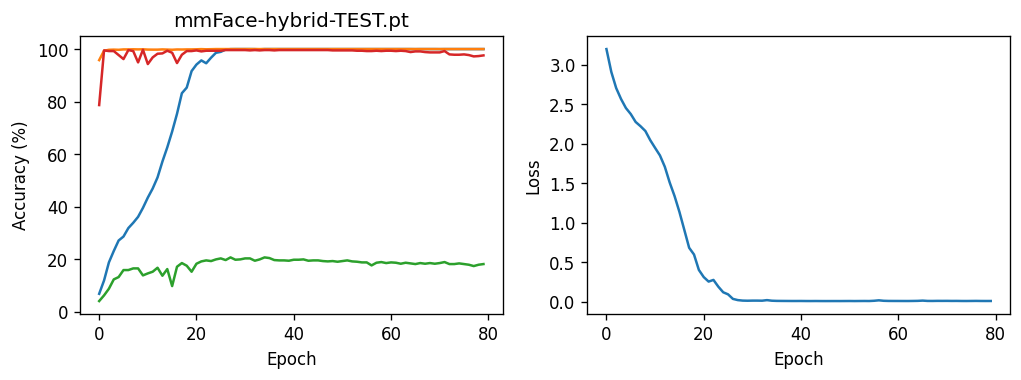

In [ ]:
import matplotlib.pyplot as plt

losses, train_acc, val_acc = load_history(f"models/{model_name}")

fig, axs = plt.subplots(1, 2, figsize=(10, 3), dpi=120)

axs[0].plot(range(len(train_acc)), train_acc)
axs[0].plot(range(len(val_acc)), val_acc)
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Accuracy (%)")

axs[1].plot(range(len(losses)), losses)
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Loss")

axs[0].set_title(model_name)
plt.show()

### Subject Confusion Matrix

[Text(0.5, 25.222222222222214, 'Predictions'),
 Text(145.22222222222223, 0.5, 'Actual'),
 Text(0.5, 1.0, 'Precision Confusion Matrix')]

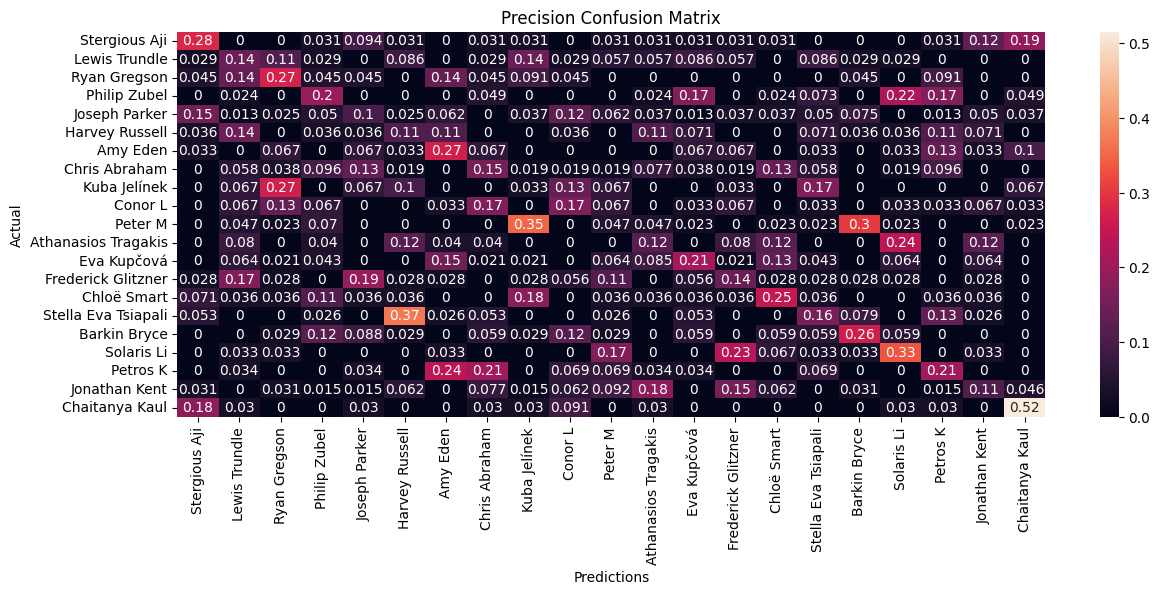

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import sys
sys.path.insert(1, "../../Soli/soli_realsense/")
from names import anon_names

subject_names = np.array(anon_names)

# Build confusion matrix
cf_matrix = confusion_matrix(preds_subject, true_subject)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index=subject_names, columns=subject_names)
plt.figure(figsize = (14, 5))
heatmap = sn.heatmap(df_cm, annot=True)
heatmap.set(xlabel ="Predictions", ylabel = "Actual", title ='Precision Confusion Matrix')

### Liveness Confusion Matrix

[Text(0.5, 25.722222222222214, 'Predictions'),
 Text(145.72222222222223, 0.5, 'Actual'),
 Text(0.5, 1.0, 'Precision Confusion Matrix')]

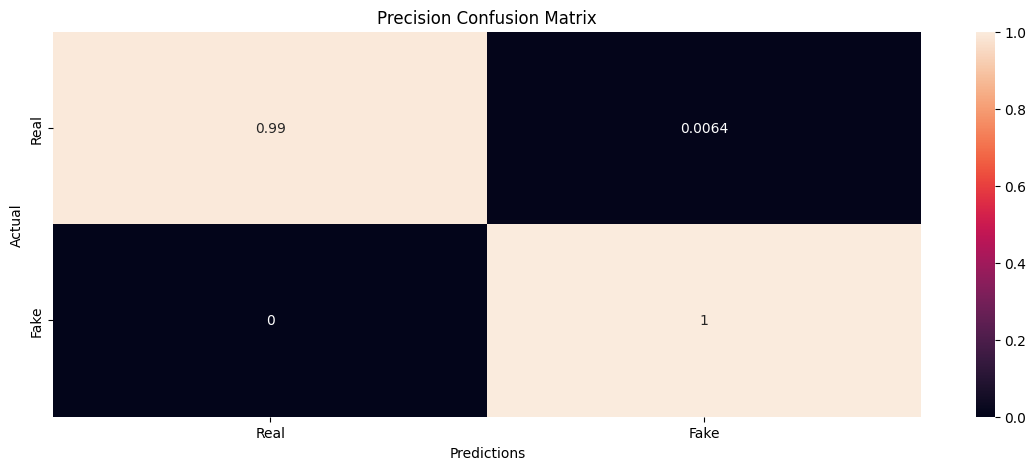

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import sys

# Build confusion matrix
cf_matrix = confusion_matrix(preds_liveness, true_liveness)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index=["Real", "Fake"], columns=["Real", "Fake"])
plt.figure(figsize = (14, 5))
heatmap = sn.heatmap(df_cm, annot=True)
heatmap.set(xlabel ="Predictions", ylabel = "Actual", title ='Precision Confusion Matrix')